In [1]:
___Author___='LumberJack Jyss'

In [2]:
print('Global Optimized LumberJack Equities Method\n°OoO_FOREX_Oo0°\nLumberJack Jyss 5779(c)')

Global Optimized LumberJack Equities Method
°OoO_FOREX_Oo0°
LumberJack Jyss 5779(c)


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [4]:
# Load sample data
df = pd.read_csv('eurusd_15mn_1Y.csv')

In [5]:
df.count()

Unnamed: 0    24483
Date          24483
Open          24483
High          24483
Low           24483
Close         24483
Volume        24483
dtype: int64

In [6]:
df.index.min(), df.index.max()

(0, 24482)

In [7]:
df.head()

,Unnamed: 0,Date,Open,High,Low,Close,Volume
0,0,20180506 23:15:00,1.195975,1.196370,1.195975,1.196155,-1
1,1,20180506 23:30:00,1.196155,1.196205,1.196020,1.196060,-1
2,2,20180506 23:45:00,1.196060,1.196325,1.195575,1.195805,-1
3,3,20180507 00:00:00,1.195805,1.196170,1.195780,1.195980,-1
4,4,20180507 00:15:00,1.195980,1.196360,1.195960,1.196255,-1


In [8]:
# Rename bid OHLC columns
df.rename(columns={'Date' : 'timestamp', 'Open' : 'open', 'Close' : 'close', 
                   'High' : 'high', 'Low' : 'low', 'Close' : 'close', 'Volume' : 'volume'}, inplace=True)
df['timestamp'] = pd.to_datetime(df['timestamp'], infer_datetime_format=True)
df.set_index('timestamp', inplace=True)
df = df.iloc[:,1:]
df = df.astype(float)
df.head()

,open,high,low,close,volume
timestamp,,,,,
2018-05-06 23:15:00,1.195975,1.196370,1.195975,1.196155,-1.0
2018-05-06 23:30:00,1.196155,1.196205,1.196020,1.196060,-1.0
2018-05-06 23:45:00,1.196060,1.196325,1.195575,1.195805,-1.0
2018-05-07 00:00:00,1.195805,1.196170,1.195780,1.195980,-1.0
2018-05-07 00:15:00,1.195980,1.196360,1.195960,1.196255,-1.0


In [9]:
# Add additional features
df['hour'] = df.index.hour
df['day']  = df.index.weekday
df['week'] = df.index.week
df['momentum']  = df['volume'] * (df['open'] - df['close'])
df['avg_price'] = (df['low'] + df['high'])/2
df['range']     = df['high'] - df['low']
df['ohlc_price'] = (df['low'] + df['high'] + df['open'] + df['close'])/4
df['oc_diff']    = df['open'] - df['close']

In [10]:
# Add PCA as a feature instead of for reducing the dimensionality. This improves the accuracy a bit.
from sklearn.decomposition import PCA

dataset = df.copy().values.astype('float32')
pca_features = df.columns.tolist()

pca = PCA(n_components=1)
df['pca'] = pca.fit_transform(dataset)

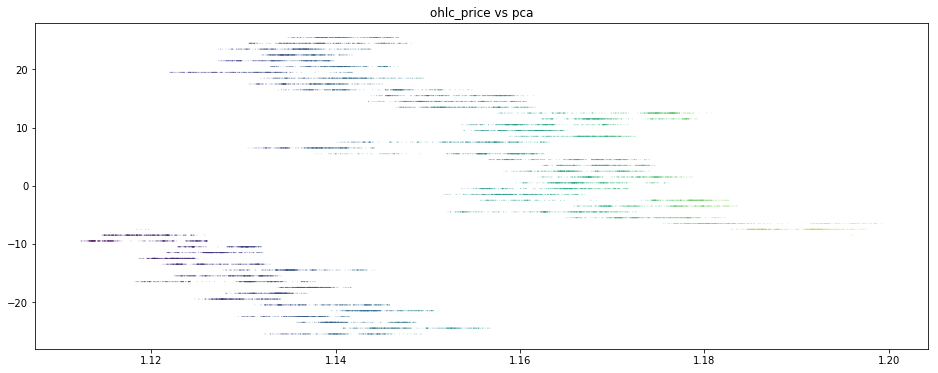

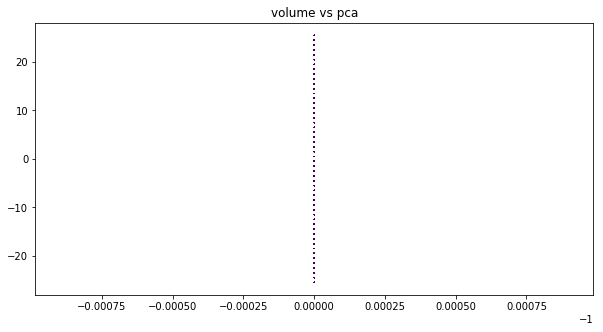

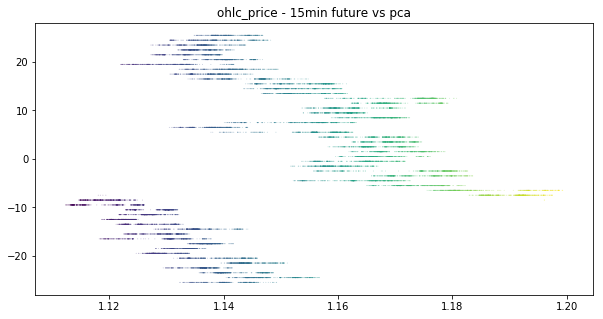

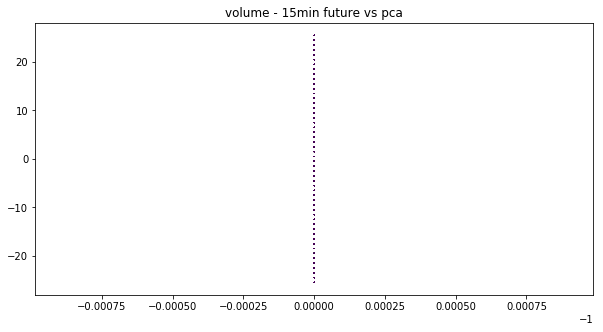

In [11]:
import matplotlib.colors as colors
import matplotlib.cm as cm
import pylab

plt.figure(figsize=(16,6))
norm = colors.Normalize(df['ohlc_price'].values.min(), df['ohlc_price'].values.max())
color = cm.viridis(norm(df['ohlc_price'].values))
plt.scatter(df['ohlc_price'].values, df['pca'].values, lw=0, c=color, cmap=pylab.cm.cool, alpha=0.3, s=1)
plt.title('ohlc_price vs pca')
plt.show()

plt.figure(figsize=(10,5))
norm = colors.Normalize(df['volume'].values.min(), df['volume'].values.max())
color = cm.viridis(norm(df['volume'].values))
plt.scatter(df['volume'].values, df['pca'].values, lw=0, c=color, cmap=pylab.cm.cool, alpha=0.3, s=1)
plt.title('volume vs pca')
plt.show()

plt.figure(figsize=(10,5))
norm = colors.Normalize(df['ohlc_price'].values.min(), df['ohlc_price'].values.max())
color = cm.viridis(norm(df['ohlc_price'].values))
plt.scatter(df['ohlc_price'].shift().values, df['pca'].values, lw=0, c=color, cmap=pylab.cm.cool, alpha=0.3, s=1)
plt.title('ohlc_price - 15min future vs pca')
plt.show()

plt.figure(figsize=(10,5))
norm = colors.Normalize(df['volume'].values.min(), df['volume'].values.max())
color = cm.viridis(norm(df['volume'].values))
plt.scatter(df['volume'].shift().values, df['pca'].values, lw=0, c=color, cmap=pylab.cm.cool, alpha=0.3, s=1)
plt.title('volume - 15min future vs pca')
plt.show()

In [12]:
def create_dataset(dataset, look_back=20):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

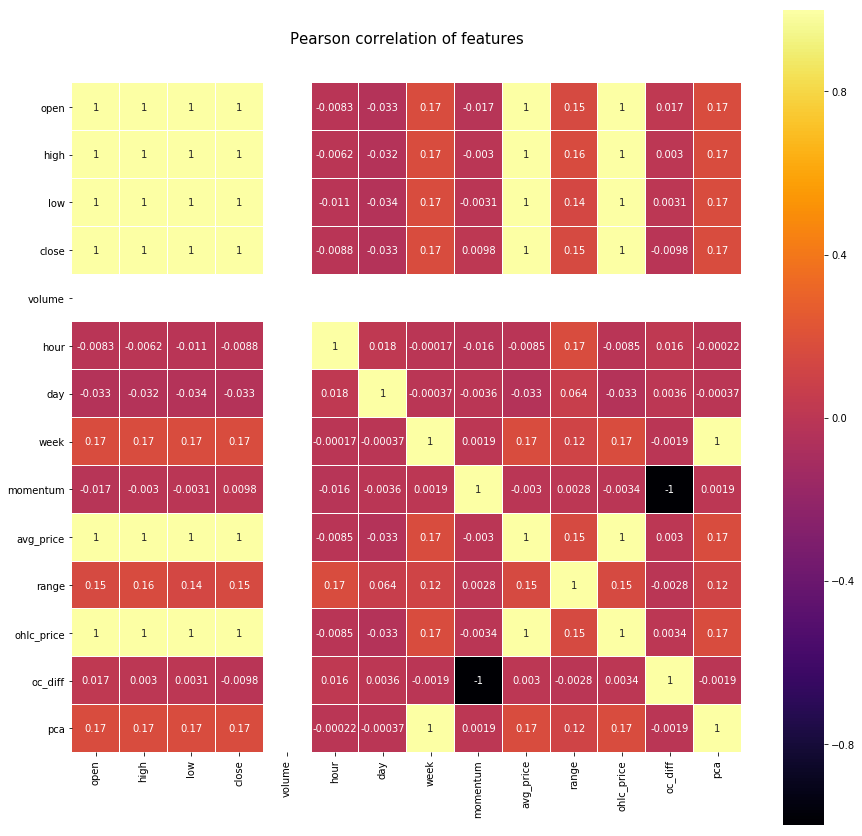

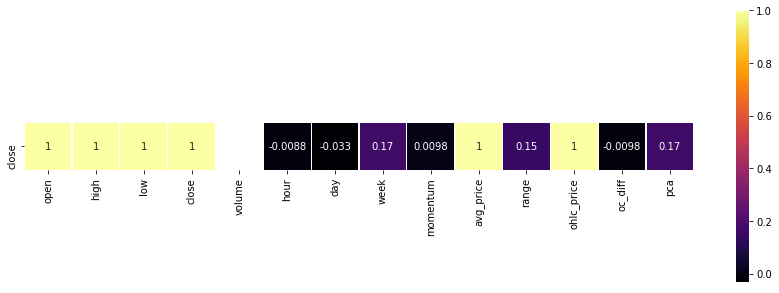

In [13]:
colormap = plt.cm.inferno
plt.figure(figsize=(15,15))
plt.title('Pearson correlation of features', y=1.05, size=15)
sns.heatmap(df.corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)
plt.show()

plt.figure(figsize=(15,5))
corr = df.corr()
sns.heatmap(corr[corr.index == 'close'], linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True);

In [14]:
from sklearn.ensemble import RandomForestRegressor

# Scale and create datasets
target_index = df.columns.tolist().index('close')
dataset = df.values.astype('float32')

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# Set look_back to 20 which is 5 hours (15min*20)
X, y = create_dataset(dataset, look_back=1)
y = y[:,target_index]
X = np.reshape(X, (X.shape[0], X.shape[2]))

In [15]:
forest = RandomForestRegressor(n_estimators = 100)
forest = forest.fit(X, y)

Feature ranking:
0. close 3 (0.746350)
1. avg_price 9 (0.170119)
2. ohlc_price 11 (0.080901)
3. low 2 (0.001939)
4. high 1 (0.000306)
5. range 10 (0.000077)
6. pca 13 (0.000076)
7. open 0 (0.000056)
8. hour 5 (0.000044)
9. momentum 8 (0.000043)
10. oc_diff 12 (0.000043)
11. day 6 (0.000025)
12. week 7 (0.000022)


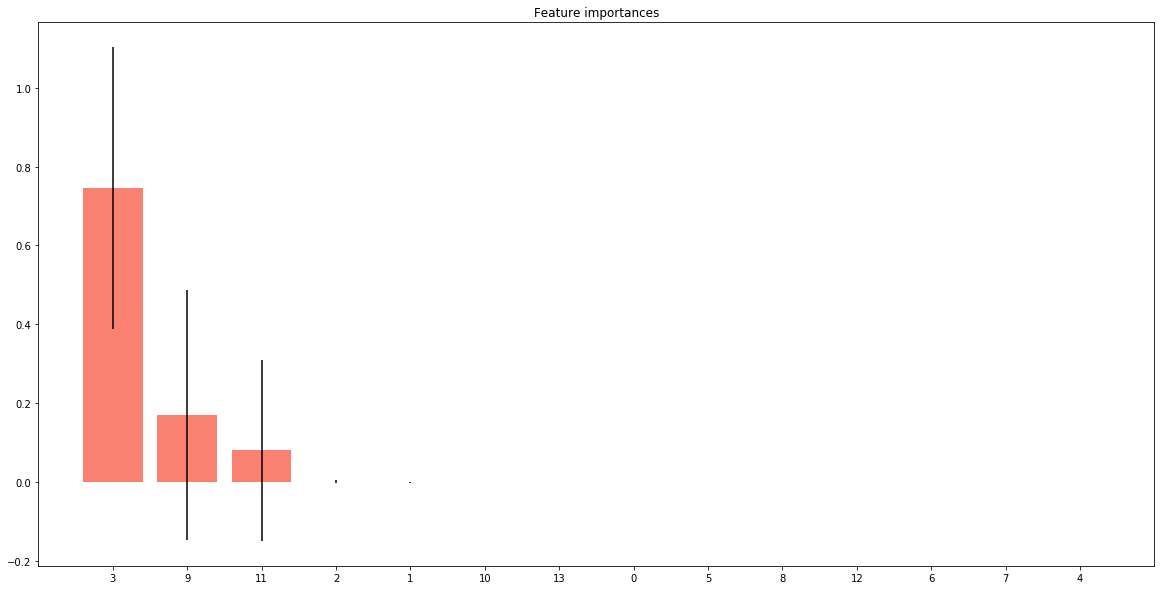

In [16]:
importances = forest.feature_importances_
std = np.std([forest.feature_importances_ for forest in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

column_list = df.columns.tolist()
print("Feature ranking:")
for f in range(X.shape[1]-1):
    print("%d. %s %d (%f)" % (f, column_list[indices[f]], indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(20,10))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="salmon", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

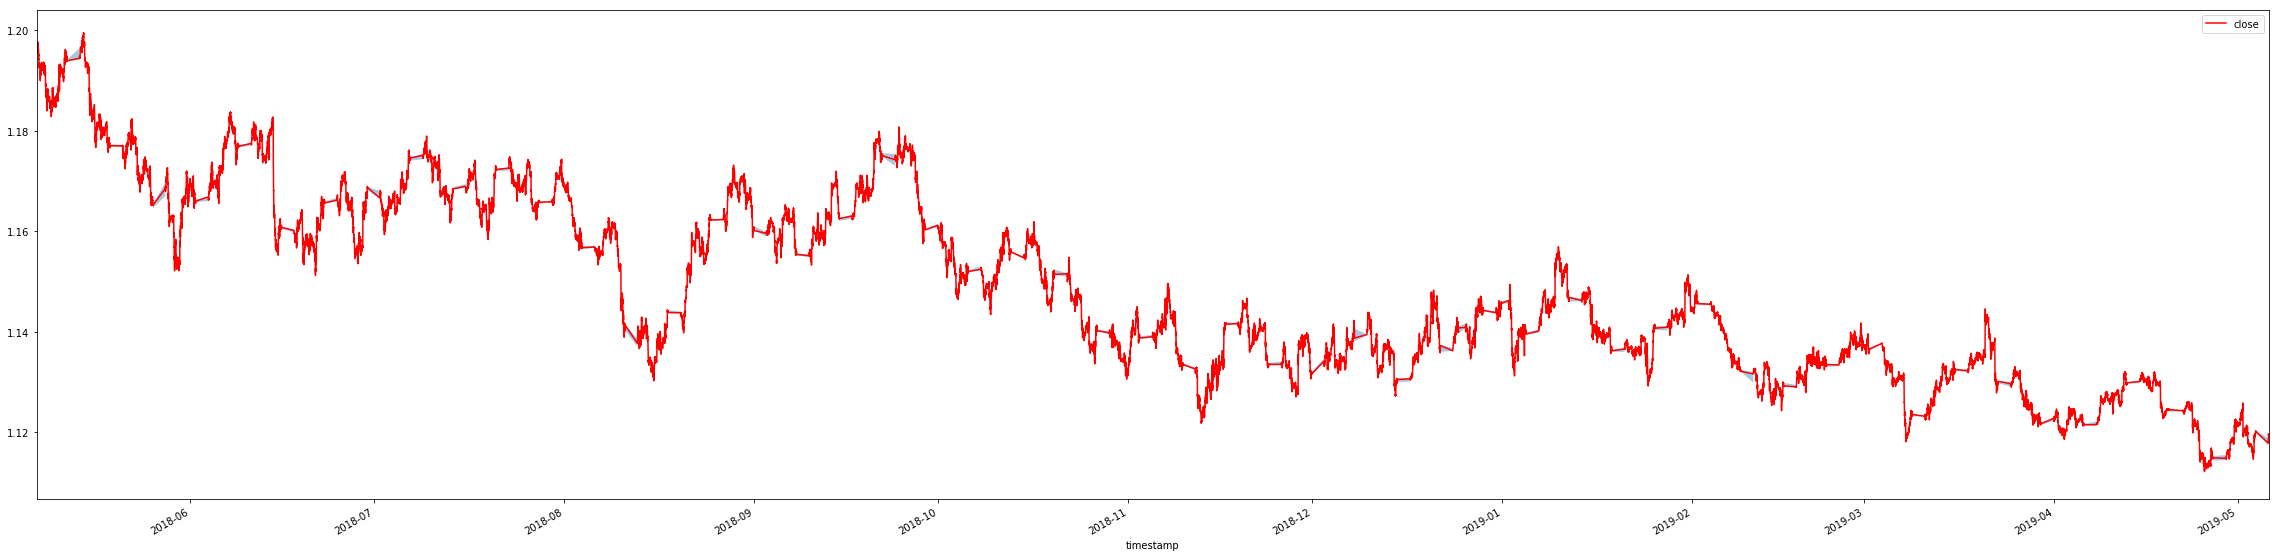

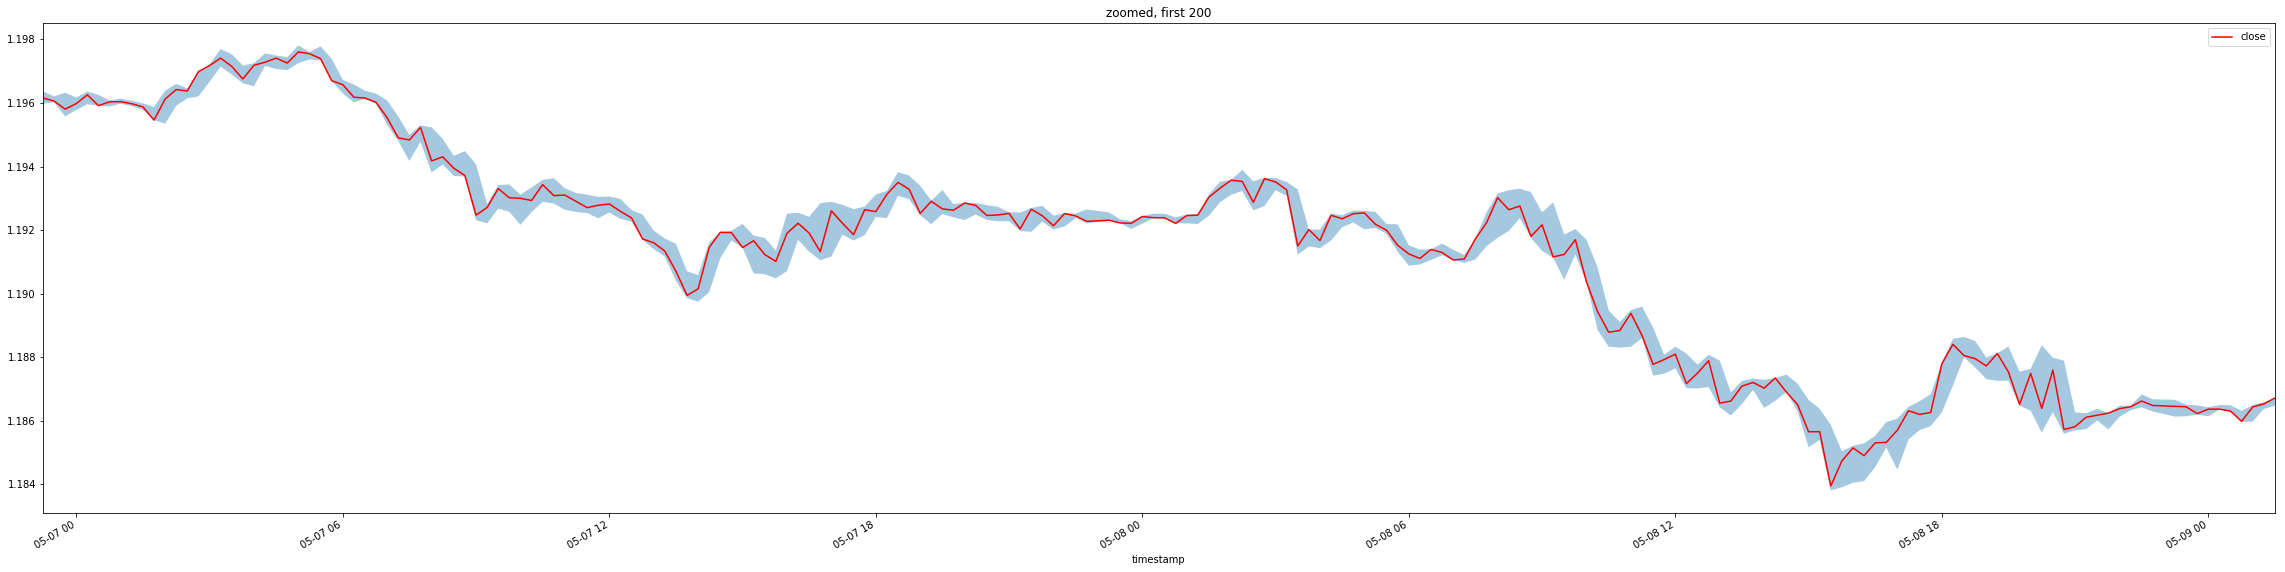

In [17]:
ax = df.plot( y='close', c='red', figsize=(40,10),)
index = [str(item) for item in df.index]
plt.fill_between(x=index, y1='low',y2='high', data=df, alpha=0.4)
plt.show()

p = df[:200].copy()
ax = p.plot( y='close', c='red', figsize=(40,10))
index = [str(item) for item in p.index]
plt.fill_between(x=index, y1='low', y2='high', data=p, alpha=0.4)
plt.title('zoomed, first 200')
plt.show()

In [18]:
# Scale and create datasets
target_index = df.columns.tolist().index('close')
high_index = df.columns.tolist().index('high')
low_index = df.columns.tolist().index('low')
dataset = df.values.astype('float32')

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# Create y_scaler to inverse it later
y_scaler = MinMaxScaler(feature_range=(0, 1))
t_y = df['close'].values.astype('float32')
t_y = np.reshape(t_y, (-1, 1))
y_scaler = y_scaler.fit(t_y)
    
# Set look_back to 20 which is 5 hours (15min*20)
X, y = create_dataset(dataset, look_back=20)
y = y[:,target_index]

In [19]:
# Set training data size
# We have a large enough dataset. So divid into 98% training / 1%  development / 1% test sets
train_size = int(len(X) * 0.99)
trainX = X[:train_size]
trainY = y[:train_size]
testX = X[train_size:]
testY = y[train_size:]

In [20]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input, LSTM, Dense

# create a small LSTM network
model = Sequential()
model.add(LSTM(20, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(LSTM(20, return_sequences=True))
model.add(LSTM(10, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(4, return_sequences=False))
model.add(Dense(4, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='uniform', activation='relu'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])
print(model.summary())

Using TensorFlow backend.
W0521 00:45:37.131738 4600567232 deprecation_wrapper.py:119] From /Users/YTsBaCh/Applications/anaconda3/envs/LumberJack/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0521 00:45:37.155301 4600567232 deprecation_wrapper.py:119] From /Users/YTsBaCh/Applications/anaconda3/envs/LumberJack/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0521 00:45:37.157536 4600567232 deprecation_wrapper.py:119] From /Users/YTsBaCh/Applications/anaconda3/envs/LumberJack/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0521 00:45:37.791550 4600567232 deprecation_wrapper.py:119] From /Users/YTsBaCh/Applications/anaconda3/envs/LumberJack/lib/python3.6/site-packa

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20, 20)            2800      
_________________________________________________________________
lstm_2 (LSTM)                (None, 20, 20)            3280      
_________________________________________________________________
lstm_3 (LSTM)                (None, 20, 10)            1240      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 10)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 4)                 240       
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total para

In [21]:
# Save the best weight during training.
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("weights.best.hdf5", monitor='val_mean_squared_error', verbose=1, save_best_only=True, mode='min')

# Fit
callbacks_list = [checkpoint]
history = model.fit(trainX, trainY, epochs=200, batch_size=500, verbose=1, callbacks=callbacks_list, validation_split=0.1)

W0521 00:45:38.637279 4600567232 deprecation.py:323] From /Users/YTsBaCh/Applications/anaconda3/envs/LumberJack/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0521 00:45:41.664667 4600567232 deprecation_wrapper.py:119] From /Users/YTsBaCh/Applications/anaconda3/envs/LumberJack/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 21795 samples, validate on 2422 samples
Epoch 1/200
21795/21795 [==============================] - 8s 371us/step - loss: 0.2421 - mean_absolute_error: 0.4522 - mean_squared_error: 0.2421 - val_loss: 0.0200 - val_mean_absolute_error: 0.1316 - val_mean_squared_error: 0.0200

Epoch 00001: val_mean_squared_error improved from inf to 0.02004, saving model to weights.best.hdf5
Epoch 2/200
21795/21795 [==============================] - 4s 202us/step - loss: 0.2421 - mean_absolute_error: 0.4522 - mean_squared_error: 0.2421 - val_loss: 0.0200 - val_mean_absolute_error: 0.1316 - val_mean_squared_error: 0.0200

Epoch 00002: val_mean_squared_error did not improve from 0.02004
Epoch 3/200
21795/21795 [==============================] - 4s 202us/step - loss: 0.2421 - mean_absolute_error: 0.4522 - mean_squared_error: 0.2421 - val_loss: 0.0200 - val_mean_absolute_error: 0.1316 - val_mean_squared_error: 0.0200

Epoch 00003: val_mean_squared_error did not improve from 0.02004
Epoch 4/200
21795/2

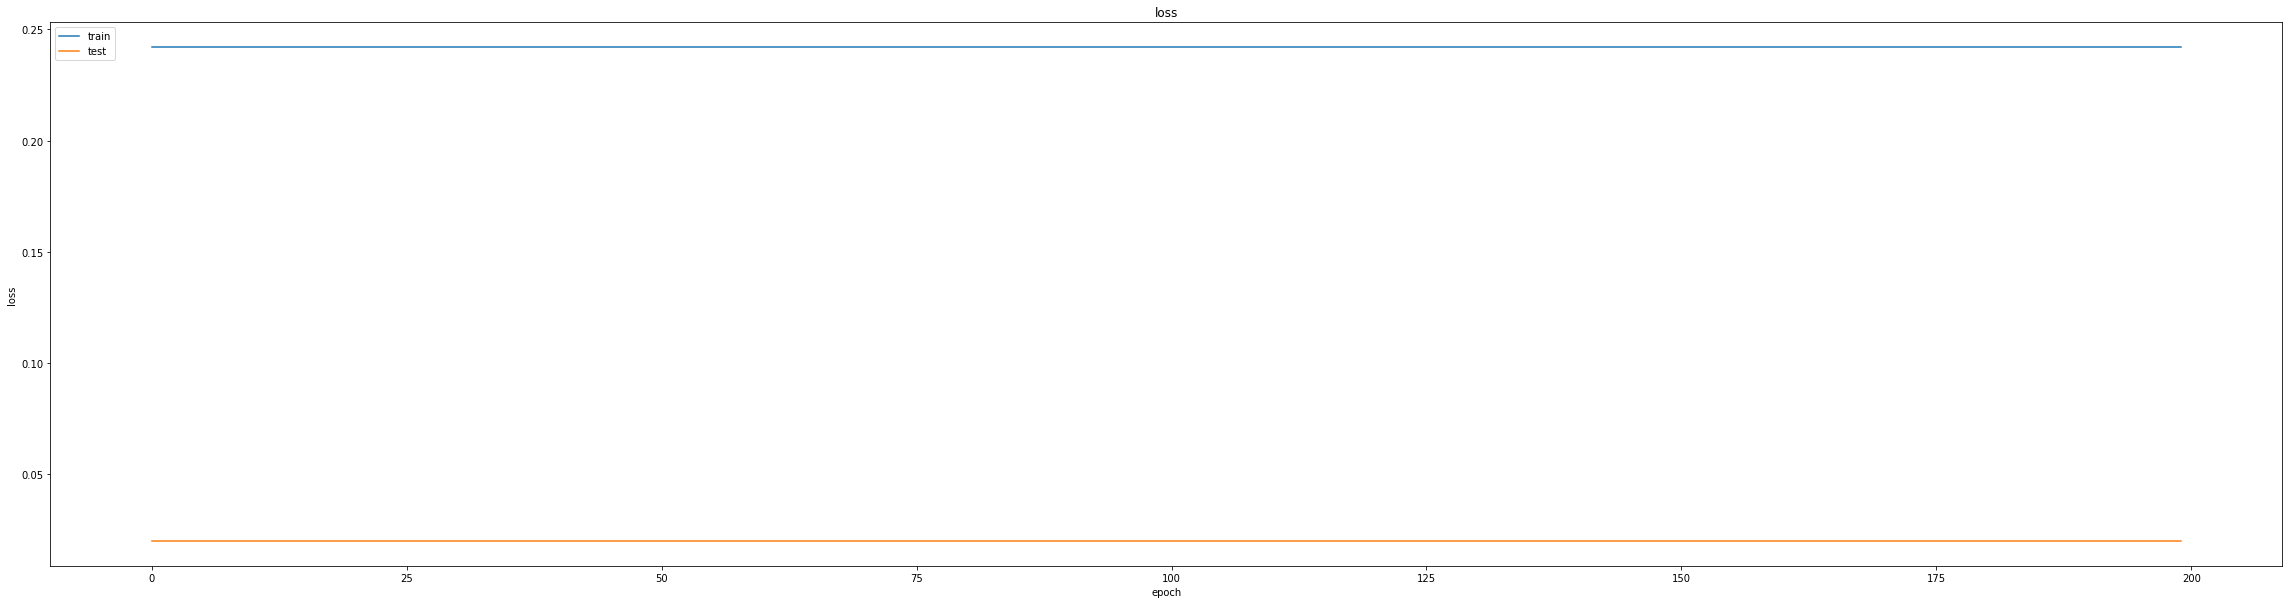

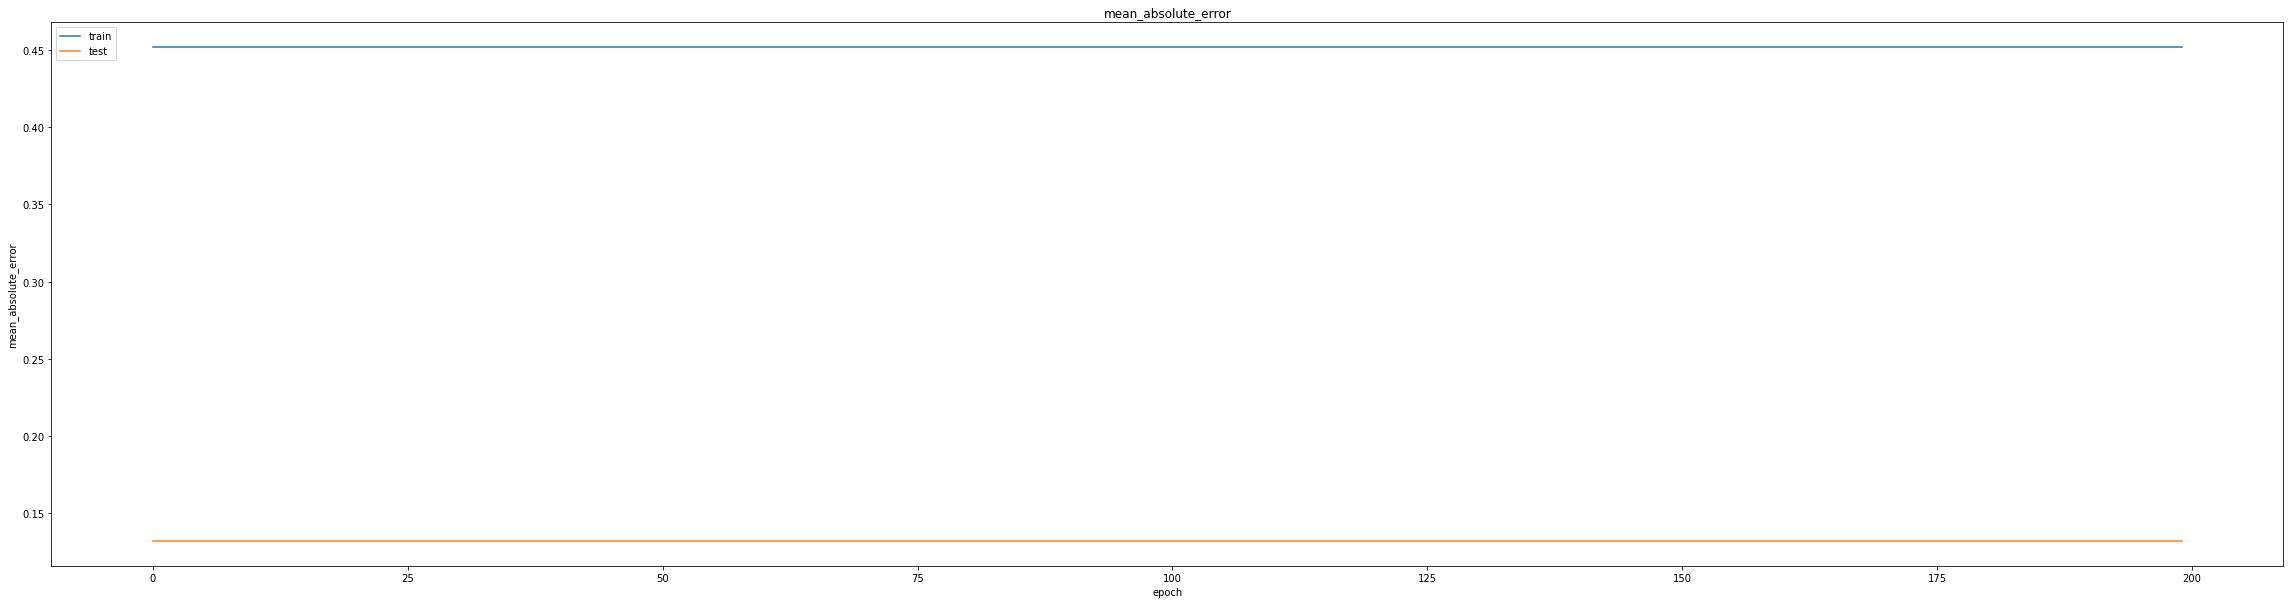

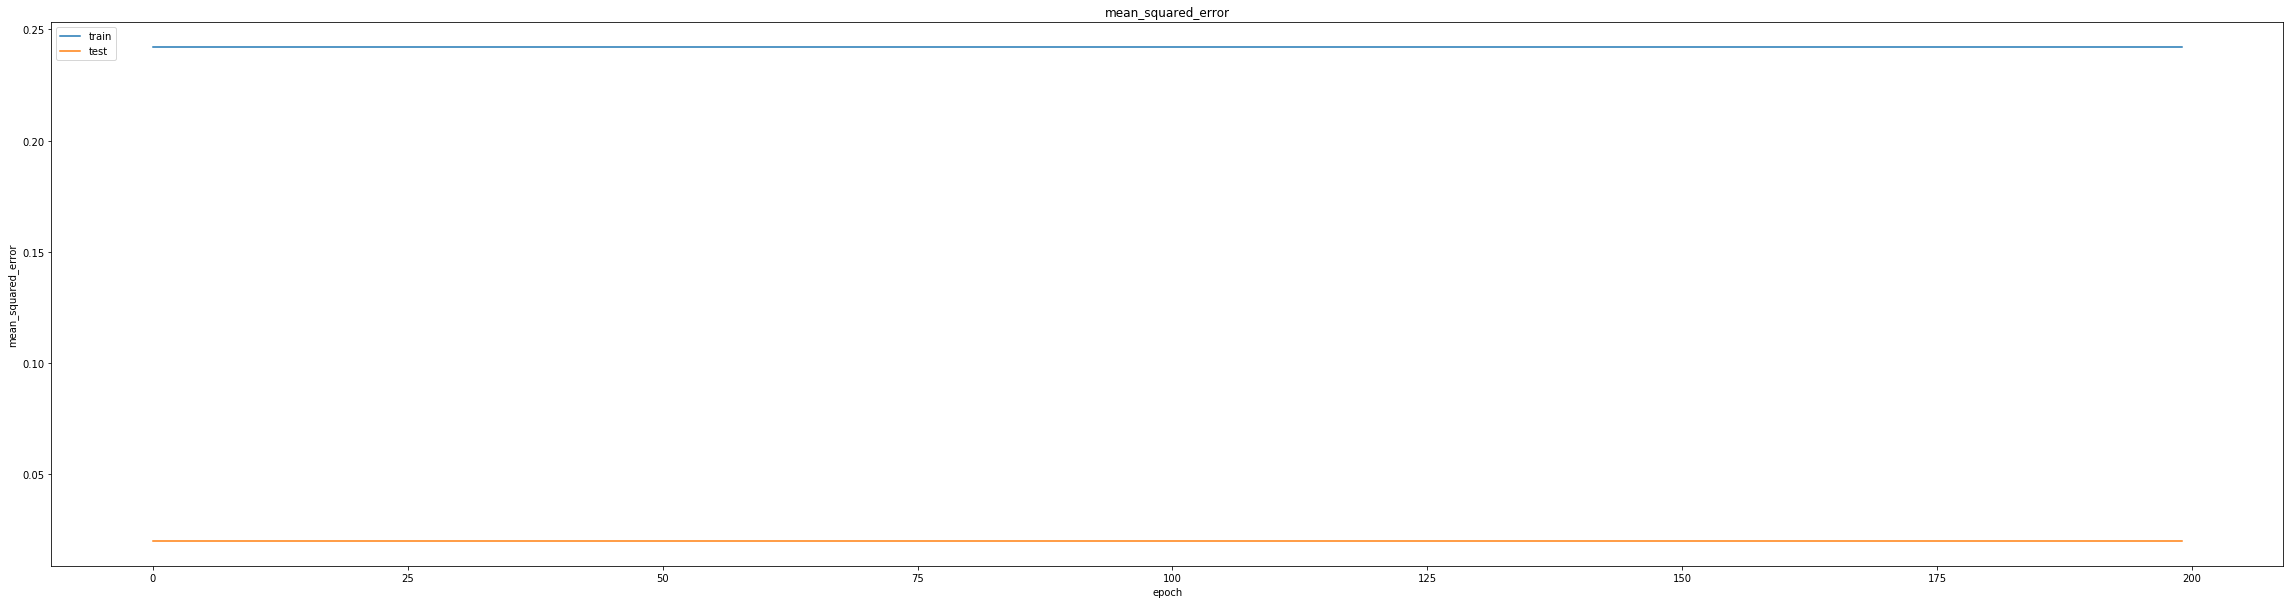

In [22]:
epoch = len(history.history['loss'])
for k in list(history.history.keys()):
    if 'val' not in k:
        plt.figure(figsize=(40,10))
        plt.plot(history.history[k])
        plt.plot(history.history['val_' + k])
        plt.title(k)
        plt.ylabel(k)
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

In [23]:
min(history.history['val_mean_absolute_error'])

0.13161554177077125

In [24]:
# Baby the model a bit
# Load the weight that worked the best
model.load_weights("weights.best.hdf5")

# Train again with decaying learning rate
from keras.callbacks import LearningRateScheduler
import keras.backend as K

def scheduler(epoch):
    if epoch%2==0 and epoch!=0:
        lr = K.get_value(model.optimizer.lr)
        K.set_value(model.optimizer.lr, lr*.9)
        print("lr changed to {}".format(lr*.9))
    return K.get_value(model.optimizer.lr)
lr_decay = LearningRateScheduler(scheduler)

callbacks_list = [checkpoint, lr_decay]
history = model.fit(trainX, trainY, epochs=int(epoch/3), batch_size=500, verbose=0, callbacks=callbacks_list, validation_split=0.1)


Epoch 00001: val_mean_squared_error did not improve from 0.02004

Epoch 00002: val_mean_squared_error did not improve from 0.02004
lr changed to 0.0009000000427477062

Epoch 00003: val_mean_squared_error did not improve from 0.02004

Epoch 00004: val_mean_squared_error did not improve from 0.02004
lr changed to 0.0008100000384729356

Epoch 00005: val_mean_squared_error did not improve from 0.02004

Epoch 00006: val_mean_squared_error did not improve from 0.02004
lr changed to 0.0007290000503417104

Epoch 00007: val_mean_squared_error did not improve from 0.02004

Epoch 00008: val_mean_squared_error did not improve from 0.02004
lr changed to 0.0006561000715009868

Epoch 00009: val_mean_squared_error did not improve from 0.02004

Epoch 00010: val_mean_squared_error did not improve from 0.02004
lr changed to 0.0005904900433961303

Epoch 00011: val_mean_squared_error did not improve from 0.02004

Epoch 00012: val_mean_squared_error did not improve from 0.02004
lr changed to 0.000531441054

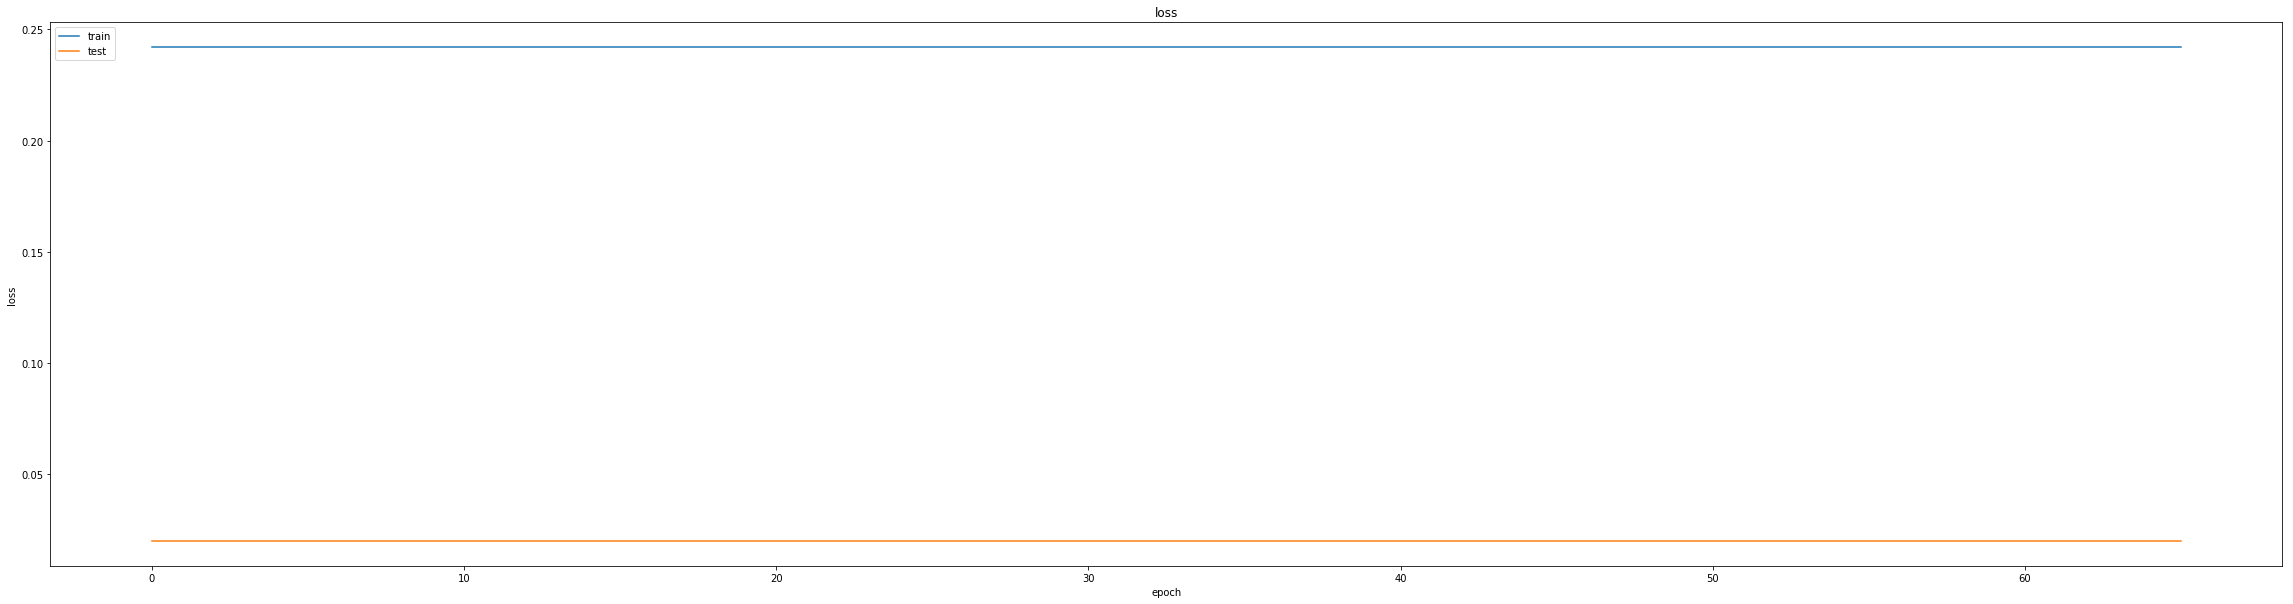

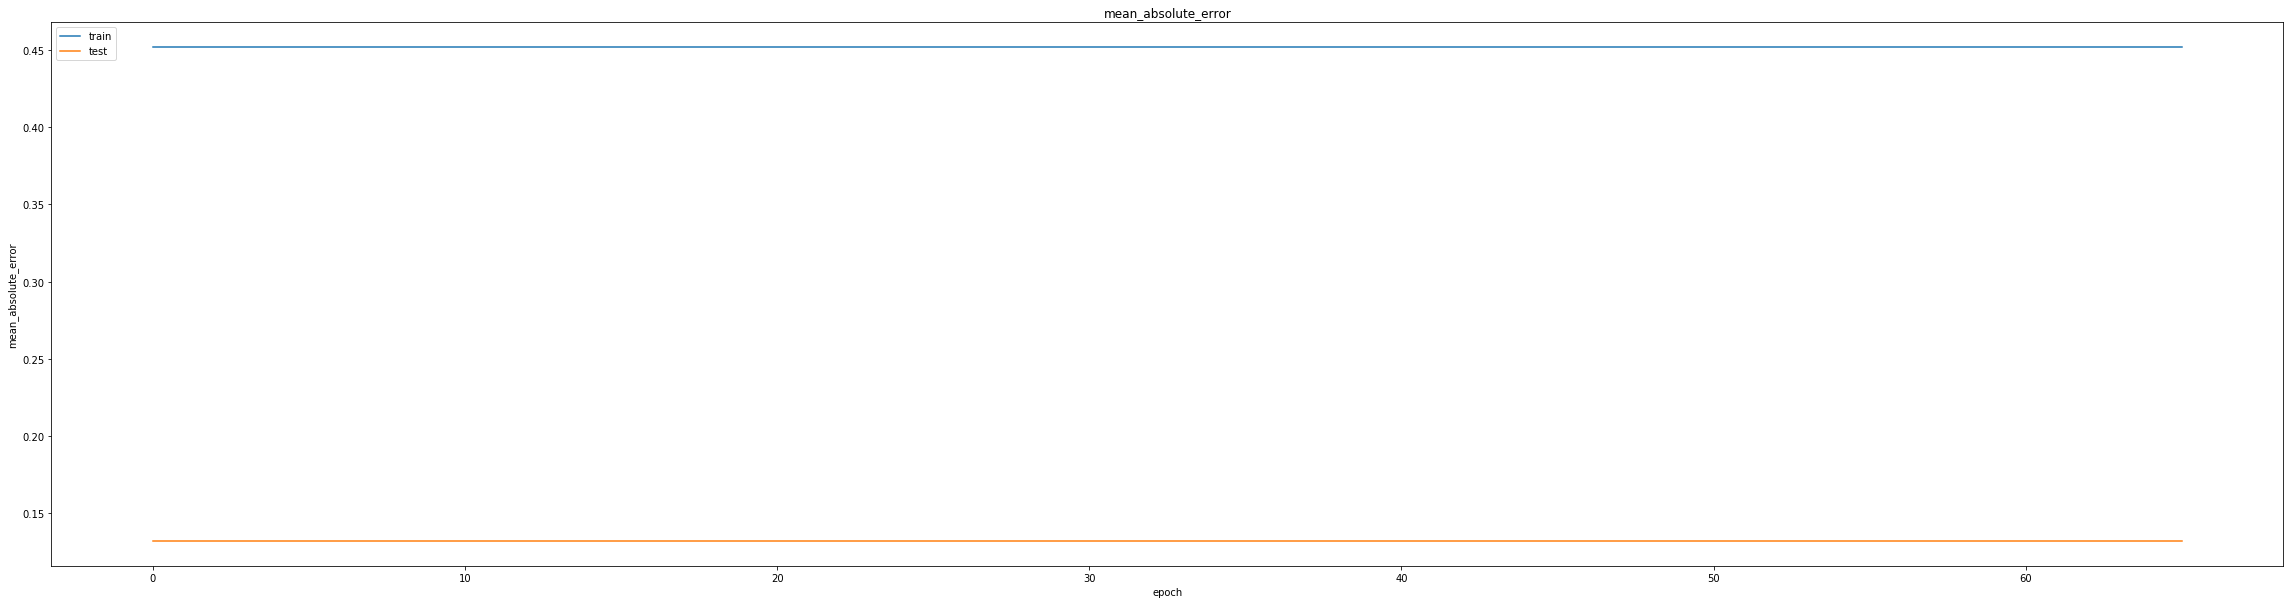

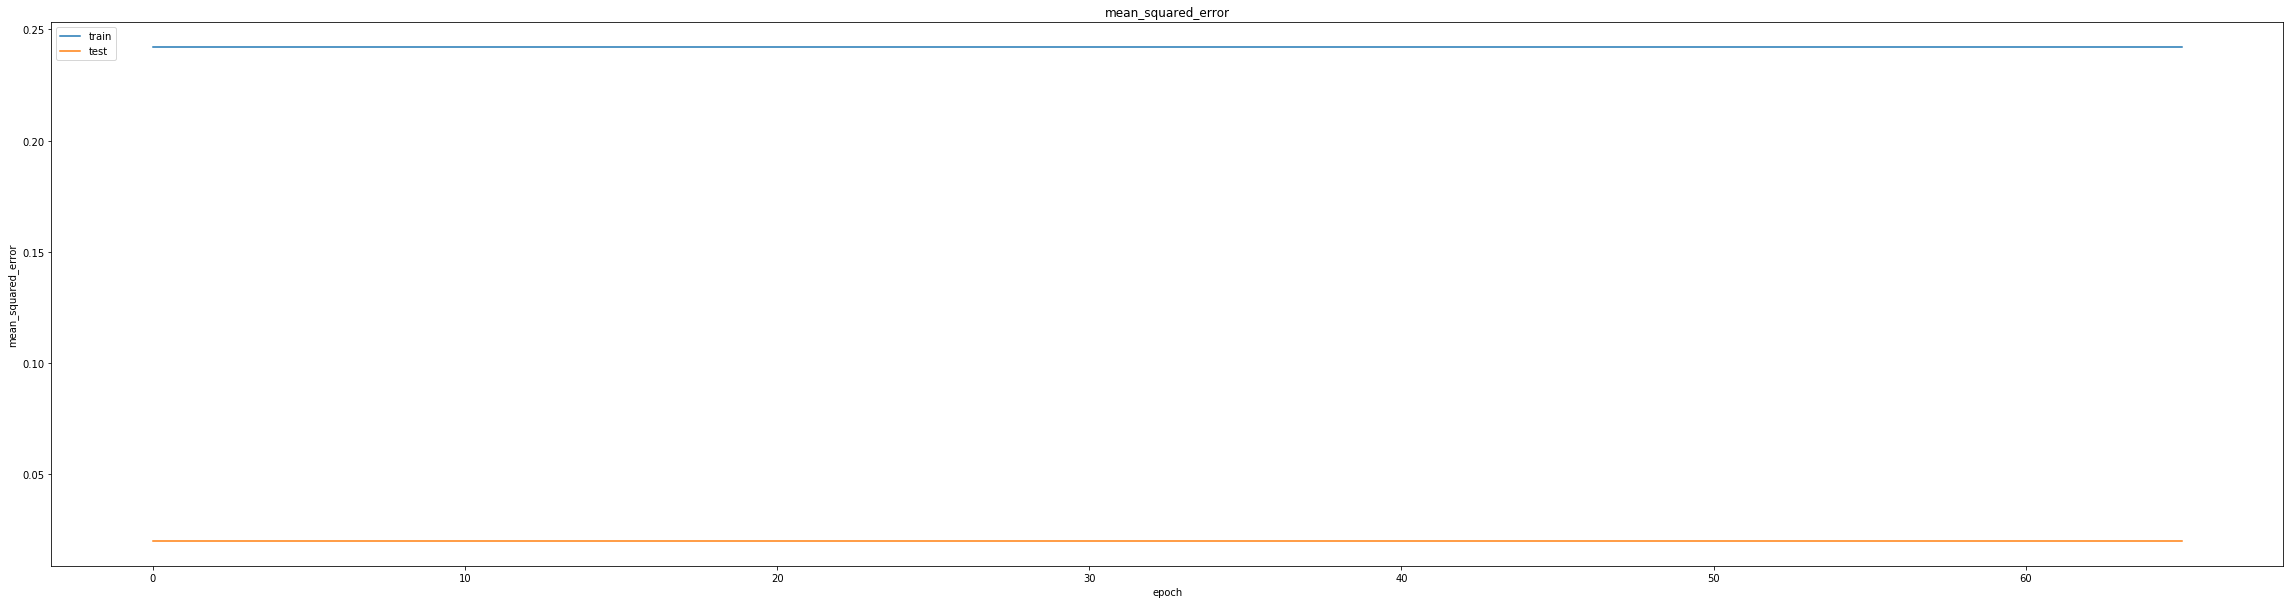

KeyError: 'val_lr'

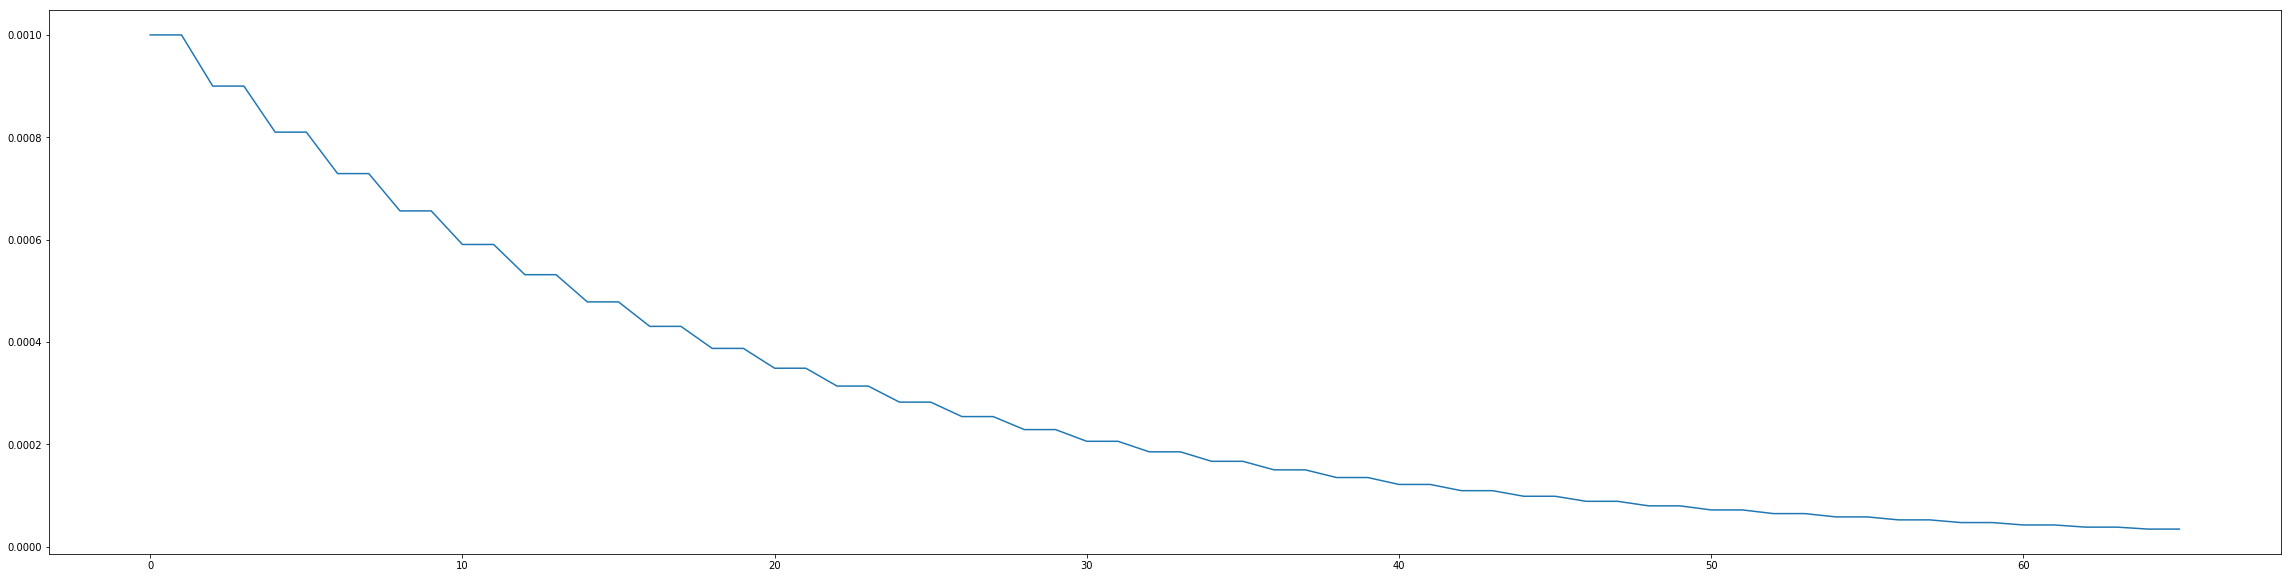

In [25]:
epoch = len(history.history['loss'])
for k in list(history.history.keys()):
    if 'val' not in k:
        plt.figure(figsize=(40,10))
        plt.plot(history.history[k])
        plt.plot(history.history['val_' + k])
        plt.title(k)
        plt.ylabel(k)
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

In [26]:
min(history.history['val_mean_absolute_error'])

0.13161554177077125

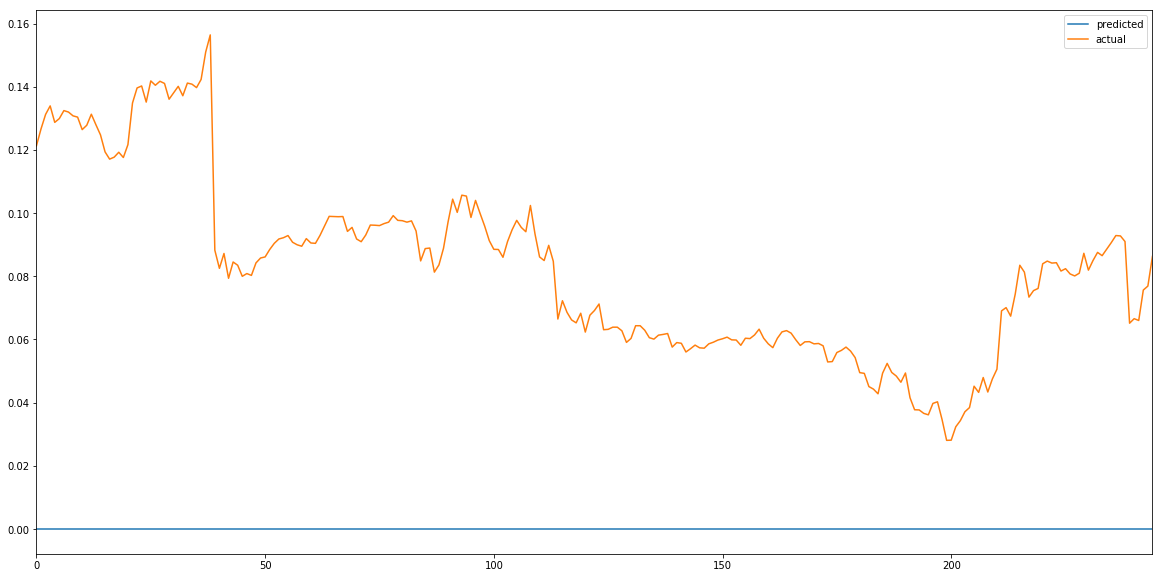

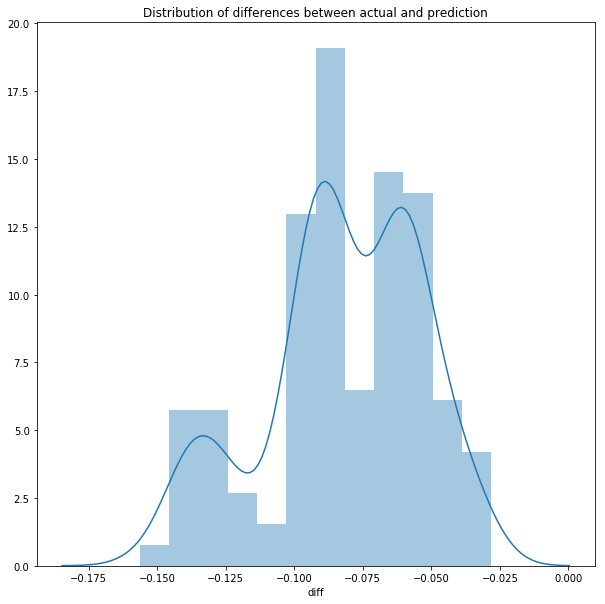

MSE :  0.007580307953588888
MAE :  0.08228152528101085


count    245.000000
mean      -0.082282
std        0.028520
min       -0.156390
25%       -0.096161
50%       -0.083495
75%       -0.059943
max       -0.028081
Name: diff, dtype: float64

In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Benchmark
model.load_weights("weights.best.hdf5")

pred = model.predict(testX)

predictions = pd.DataFrame()
predictions['predicted'] = pd.Series(np.reshape(pred, (pred.shape[0])))
predictions['actual'] = testY
predictions = predictions.astype(float)

predictions.plot(figsize=(20,10))
plt.show()

predictions['diff'] = predictions['predicted'] - predictions['actual']
plt.figure(figsize=(10,10))
sns.distplot(predictions['diff']);
plt.title('Distribution of differences between actual and prediction')
plt.show()

print("MSE : ", mean_squared_error(predictions['predicted'].values, predictions['actual'].values))
print("MAE : ", mean_absolute_error(predictions['predicted'].values, predictions['actual'].values))
predictions['diff'].describe()

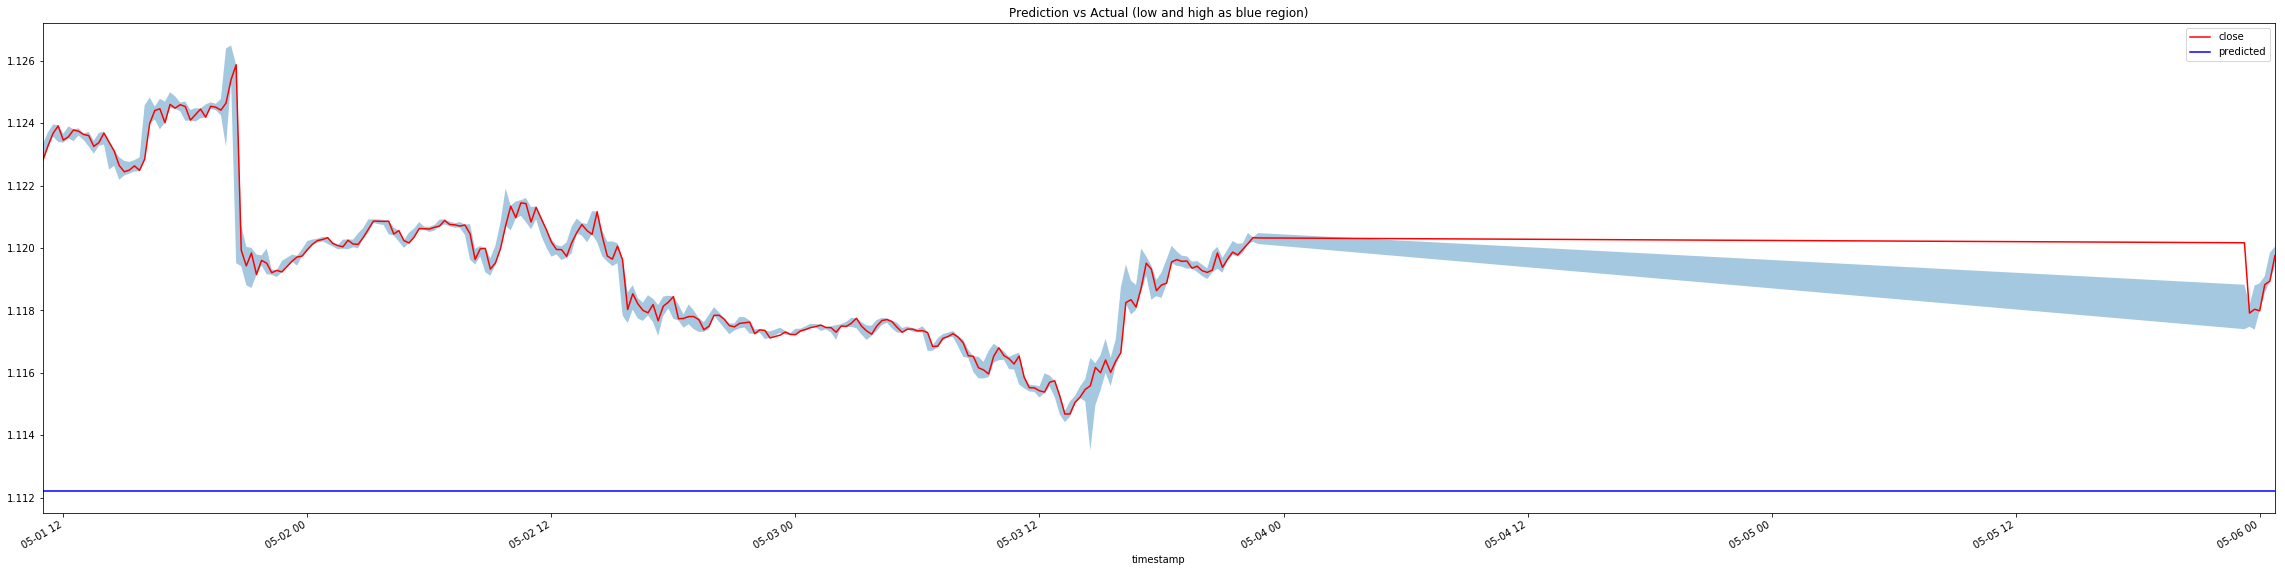

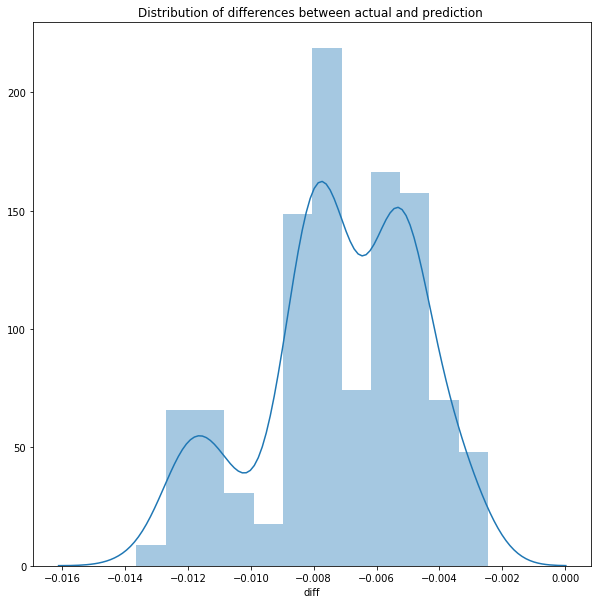

/Users/YTsBaCh/Applications/anaconda3/envs/LumberJack/lib/python3.6/site-packages/statsmodels/nonparametric/kernels.py:128: RuntimeWarning: invalid value encountered in true_divide
  return (1. / np.sqrt(2 * np.pi)) * np.exp(-(Xi - x)**2 / (h**2 * 2.))
/Users/YTsBaCh/Applications/anaconda3/envs/LumberJack/lib/python3.6/site-packages/matplotlib/contour.py:1557: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/Users/YTsBaCh/Applications/anaconda3/envs/LumberJack/lib/python3.6/site-packages/matplotlib/contour.py:1558: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/Users/YTsBaCh/Applications/anaconda3/envs/LumberJack/lib/python3.6/site-packages/matplotlib/contour.py:1203: RuntimeWarning: invalid value encountered in less
  under = np.nonzero(lev < self.zmin)[0]
/Users/YTsBaCh/Applications/anaconda3/envs/LumberJack/lib/python3.6/site-packages/matplotlib/contour.py:1205: RuntimeWarning: invalid value encountered 

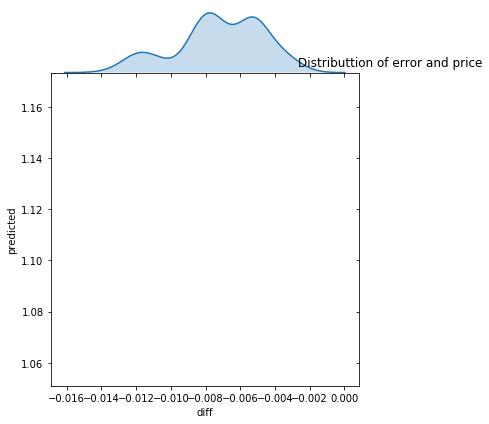

MSE :  5.7706053323564835e-05
MAE :  0.007179095793743523


count    245.000000
mean      -0.007179
std        0.002488
min       -0.013645
25%       -0.008390
50%       -0.007285
75%       -0.005230
max       -0.002450
Name: diff, dtype: float64

In [29]:
pred = model.predict(testX)
pred = y_scaler.inverse_transform(pred)
close = y_scaler.inverse_transform(np.reshape(testY, (testY.shape[0], 1)))
predictions = pd.DataFrame()
predictions['predicted'] = pd.Series(np.reshape(pred, (pred.shape[0])))
predictions['close'] = pd.Series(np.reshape(close, (close.shape[0])))

p = df[-pred.shape[0]:].copy()
predictions.index = p.index
predictions = predictions.astype(float)
predictions = predictions.merge(p[['low', 'high']], right_index=True, left_index=True)

ax = predictions.plot(y='close', c='red', figsize=(40,10))
ax = predictions.plot(y='predicted', c='blue', figsize=(40,10), ax=ax)
index = [str(item) for item in predictions.index]
plt.fill_between(x=index, y1='low', y2='high', data=p, alpha=0.4)
plt.title('Prediction vs Actual (low and high as blue region)')
plt.show()

predictions['diff'] = predictions['predicted'] - predictions['close']
plt.figure(figsize=(10,10))
sns.distplot(predictions['diff']);
plt.title('Distribution of differences between actual and prediction ')
plt.show()

g = sns.jointplot("diff", "predicted", data=predictions, kind="kde", space=0)
plt.title('Distributtion of error and price')
plt.show()

# predictions['correct'] = (predictions['predicted'] <= predictions['high']) & (predictions['predicted'] >= predictions['low'])
# sns.factorplot(data=predictions, x='correct', kind='count')

print("MSE : ", mean_squared_error(predictions['predicted'].values, predictions['close'].values))
print("MAE : ", mean_absolute_error(predictions['predicted'].values, predictions['close'].values))
predictions['diff'].describe()

In [ ]:
print('ok')